# Sieć neuronowa 

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('data.csv')
data.describe()
X = data[['x1','x2']]
y = to_categorical(data['t'])
X_train, X_test,y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.3)

Używamy funkcji sigmoid, ponieważ rozważamy model z dwiema etykietami wyjściowymi.

In [770]:
model = Sequential()
model.add(Dense(10, input_shape=(2,), activation = 'relu'))
model.add(Dense(2, activation='softmax')) 
model.summary()

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_126 (Dense)           (None, 10)                30        
                                                                 
 dense_127 (Dense)           (None, 2)                 22        
                                                                 
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________


Jako fukcję starty używamy 'binary_crossentropy', ponieważ rozważamy problem klasyfikacji dwóch klas oraz wartości 
etykiety wyjściowej są przedstawione jako one-hot encoding. Zbiór został przetrenowany na funkcjach optymalizacji (optimizers) Adam oraz SGD dla różnych learning rates oraz zostały porównane otrzymane dla nich dokładności (accuracy). Najlepsza dokładność została otrzymana dla funkcji optymalizacji'adam' z learning_rate = 0.004.

In [771]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10)
opt = Adam(learning_rate=0.004)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs = 100, validation_split=0.3, callbacks=early_stopping)

Epoch 1/100
16/16 [==============================] - 1s 19ms/step - loss: 1.4528 - accuracy: 0.4029 - val_loss: 1.0493 - val_accuracy: 0.5592
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.9228 - accuracy: 0.5890 - val_loss: 0.6817 - val_accuracy: 0.7393
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.5883 - accuracy: 0.7894 - val_loss: 0.4595 - val_accuracy: 0.8436
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.3980 - accuracy: 0.8671 - val_loss: 0.3356 - val_accuracy: 0.8531
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.2993 - accuracy: 0.8834 - val_loss: 0.2683 - val_accuracy: 0.8768
Epoch 6/100
16/16 [==============================] - 0s 7ms/step - loss: 0.2449 - accuracy: 0.8937 - val_loss: 0.2291 - val_accuracy: 0.8910
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 0.2127 - accuracy: 0.9039 - val_loss: 0.2037 - val_accuracy: 0.9147
Epoch 8/100


Proces uczenia został zatrzymany na 40 epokach dzięki funkcji EarlyStopping. Gdy przez 10 epok dokładność zbioru walidacyjnego nie poprawiała się, trenowanie zostało zatrzymane. Dzięki temu zbiór nie zsotał przetrenowany. Zbiór walidacyjny stanowi 30% zbioru treningowego.

In [772]:
accuracy = model.evaluate(X_test, y_test)[1]
print(accuracy)

10/10 [==============================] - 0s 3ms/step - loss: 0.0599 - accuracy: 0.9833
0.9833333492279053


Dokładność modelu wynosi 98.33%

In [773]:
preds = model.predict(X_test)
preds = np.around(preds)
summary = pd.DataFrame({'Actual' : y_test[:,0], 'Predicted' : preds[:,0]})
summary['if_equal'] = np.where((summary['Actual'] == summary['Predicted']), 'equal', 'notequal')
print(summary.loc[summary['if_equal'] == 'notequal'])

10/10 [==============================] - 0s 2ms/step
     Actual  Predicted  if_equal
34      0.0        1.0  notequal
44      0.0        1.0  notequal
172     0.0        1.0  notequal
249     0.0        1.0  notequal
275     0.0        1.0  notequal


Powyższa tabelka przedstawia dla których wierszy wyniki przewidywane i rzeczywiste są od siebie różne. Takich obserwacji jest pięć.

<function matplotlib.pyplot.show(close=None, block=None)>

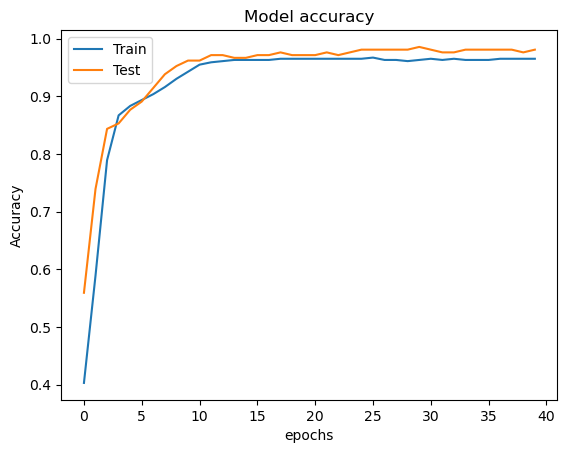

In [774]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.legend(['Train', 'Test'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show

Dokładność zbioru testowego i trenowanego prawie idealnie na siebie nachodzi, co oznacza, że zbiór nie został przetrenowany (overfitted). Trenowanie zostało zatrzymane w odpowiednim momencie i zbór osiągnał optymalną dokładność.

<function matplotlib.pyplot.show(close=None, block=None)>

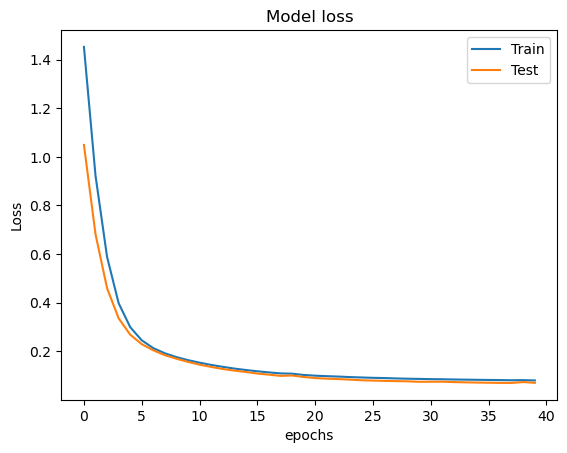

In [775]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.legend(['Train', 'Test'])
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show

Funkcje straty dla zbioru trenowanego i testowego nachodzą na siebie i się wypłaszczają. Oznacza to, że zbiór nie wymaga dalszego trenowania oraz nie został przetrenowany (overfitted). 

# Regresja logistyczna

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import numpy as np
import seaborn as sns
import time
from sklearn.metrics import roc_curve, roc_auc_score

In [9]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [20]:
model_df = pd.DataFrame()
def solver(name):
    global model_df
    global model_reg
    model_reg = LogisticRegression(solver=name)    
    start_time = time.time() 
    model_reg.fit(X_train, y_train[:,0])
    end_time = time.time()
    score = model_reg.score(X_test, y_test[:,0])
    param_dict = { 'algorithm': name, 'score': score, 'time': end_time - start_time}
    model_df = model_df.append(pd.DataFrame(param_dict, index=[0]))
    model_df.reset_index(drop=True, inplace=True)


In [21]:
solver('lbfgs')
solver('saga')
solver('sag')
solver('newton-cg')
solver('liblinear')

In [17]:
model_df

,algorithm,score,time
0,lbfgs,0.983333,0.015953
1,saga,0.983333,0.018951
2,sag,0.983333,0.008012
3,newton-cg,0.983333,0.010938
4,liblinear,0.983333,0.002991


Jak można zauważyć w powyższej tabelce wybór algorytmu nie ma znaczenia, ponieważ przewidywane prawdopodobieństwo dokładności
modelu (score) jest takie samo dla każdego wariantu. Również nie ma większych różnic dla czasu trenowania zbioru między algorytmami.

In [22]:
preds_reg = model_reg.predict(X_test)
preds_reg
#"1" oznaczają wynik "0" dla kolumny t

array([0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
       1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0.,
       1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 1., 1., 1., 0.

In [787]:
cm = metrics.confusion_matrix(y_test[:,0], preds_reg)
print(cm)

[[152   4]
 [  1 143]]


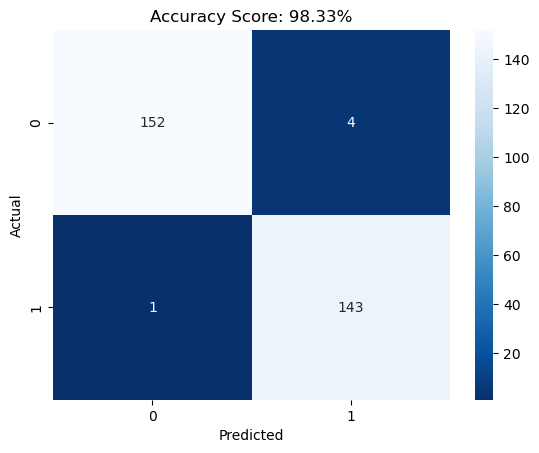

In [788]:
sns.heatmap(cm, annot=True, fmt=".0f", cmap = 'Blues_r');
plt.ylabel('Actual');
plt.xlabel('Predicted');
#all_sample_title = 
plt.title('Accuracy Score: {0}%'.format(round(score*100,2)));

Na powyższej mapie ciepła można zaobserwować, że pięć obserwacji zostało zakwalifikowanych błędnie.

In [789]:
result = pd.DataFrame({'Actual' : y_test[:,0], 'Predicted' : preds_reg})
result['if_equal'] = np.where((result['Actual'] == result['Predicted']), 'equal', 'notequal')
print(result.loc[result['if_equal'] == 'notequal'])

     Actual  Predicted  if_equal
34      0.0        1.0  notequal
44      0.0        1.0  notequal
78      0.0        1.0  notequal
158     1.0        0.0  notequal
172     0.0        1.0  notequal


W powyższej tabelce możemy zauważyć, że dla wymienionych wierszy wyniki przewidywane i rzeczywiste się różnią.

In [44]:
preds_proba = model_reg.predict_proba(X_test)[:,1]
preds_proba

array([5.67381903e-02, 9.77684887e-01, 1.99717364e-03, 1.09504378e-04,
       2.98401341e-02, 1.30530010e-03, 9.99992836e-01, 9.92542146e-01,
       1.30350171e-01, 9.96441997e-01, 9.95523625e-01, 1.28776939e-02,
       9.99028548e-01, 9.99862697e-01, 9.99997787e-01, 1.08437267e-03,
       9.99991348e-01, 9.99944797e-01, 3.97764549e-02, 2.12566532e-03,
       9.81289980e-01, 9.68521417e-01, 6.49950858e-04, 1.52934692e-04,
       9.68241670e-01, 7.95195302e-03, 4.22446132e-04, 9.79249814e-01,
       2.53376884e-05, 1.14541061e-05, 3.13209853e-04, 9.93420390e-05,
       7.22100090e-03, 5.95375260e-05, 9.55883507e-01, 9.99184114e-01,
       2.01856327e-01, 3.44725845e-01, 9.97512043e-01, 9.95208516e-01,
       2.64052412e-02, 2.66935773e-04, 9.47956759e-03, 2.45755783e-03,
       8.19142343e-01, 9.16268803e-05, 9.31516745e-02, 2.58295618e-05,
       6.65782935e-01, 1.73471590e-04, 8.61467262e-04, 8.81888018e-01,
       4.24439498e-05, 9.99998021e-01, 9.75997390e-01, 3.21633684e-02,
      

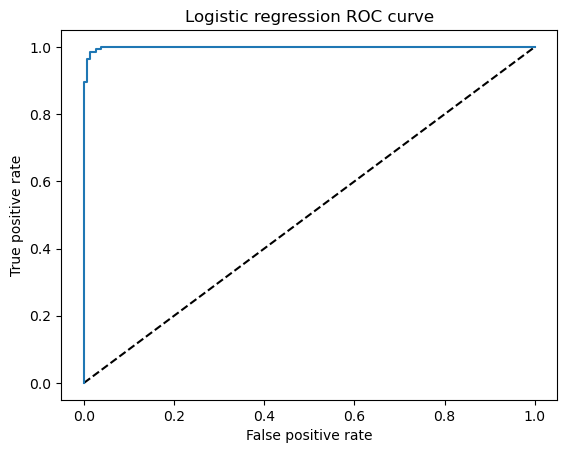

In [42]:
fpr, tpr, tresholds = roc_curve(y_test[:,0], preds_proba)
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic regression ROC curve')
plt.show()

In [43]:
print(roc_auc_score(y_test[:,0], preds_reg))

0.983707264957265


Z powyższego wykresu można zaobserwować, że krzywa ROC jest blisko modelu idealnego. Pole powierzchni pomiędzy krzywą ROC modelu predykcyjnego i krzywą ROC dla modelu losowego wynosi 98,37%, co zgadza się z przewidywanymi prawdopodobieństwami dokładności modelu regresji logistycznej oraz sieci neuronowej.

# Podsumowanie:

Model sieci neuronowej jest bardzo zbliżony do modelu legresji logistycznej. W obu przypadkach przewidywane prawdopodobieństwo dokładności modelu wynosi 98,33% i dane przewidywane i rzeczywiste różnią się od siebie w obu metodach dla pięciu wierszy. Można zatem wywnioskować, że dla zbioru 'data' regresja logistyczna i sieć neuronowa są tak samo wydajnymi metodami.